# Telco Churn

## Project Goals
* Identify drivers of churn for Telco customers
* Use the identified drivers to develop a model to determine if a customer is likely to churn
* Churn is defined as a customer who has left Telco
* This information can be useful to help Telco find ways to retain customers who are likely to churn.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

#import my personal modules created for this report
import wrangle as w
import explore as e
import model as m

## Acquire

* Data acquired from the Codeup mySQL server on October 26, 2022
* It contained 7043 rows and 24 columns
* Each observation represents a Telco customer
* Each column represents a feature of those customers

In [2]:
#import unclean data from Codeup mySQL server
telco_unclean = w.get_telco_data()

## Prepare

* Checked for duplicate rows (there were none)
* Removed redundant data columns (payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id')
* Checked for nulls in the data (there were none)
* Checked that column data types were appropriate
* Noticed "total_charges" was listed as an object so researched why and found some customers have spaces (" ")
* Dropped those customers whose total_charges are spaces (these customers are new customers (tenure=0 and churn=No)), then converted to a float (11 rows)
* Encoded target variable, churn, as 'churn_encoded' {'Yes': 1, 'No': 0}, then dropped 'churn' column
* Split data into train, validate, and test (65/20/15)
* Outliers have not been removed for this iteration of the project

In [3]:
#clean the data to prep for exploration
telco = w.clean_telco(telco_unclean)

# splitting data into train, validate, and test
train, validate, test = w.train_validate_test_split(telco, "churn_encoded")

### Data dictionary
| Feature | Definition | Values |
|:--------|:-----------|:-------
|gender| The customer's gender| Male or Female|
|senior_citizen| Is this customer a senior citizen?| {'Yes': 1, 'No': 0} |
|partner| Does this person live with a partner?|'Yes', 'No'|
|dependents| Does this person live with dependents?| 'Yes', 'No'|
|tenure| The number of **months** a customer has been with the company| *int* |
|phone_service| Does this person subscribe to phone service?| 'Yes', 'No'|
|multiple_lines| Does this person have multiple phone lines?| 'Yes', 'No', 'No phone service'|
|online_security| Does this person subscribe to online security?| 'Yes', 'No', 'No internet service'|
|online_backup| Does this person subscribe to online backup?| 'Yes', 'No', 'No internet service'
|device_protection| Does this person subscribe to device protection?| 'Yes', 'No', 'No internet service'
|tech_support| Does this person subscribe to tech support?| 'Yes', 'No', 'No internet service'
|streaming_tv| Does this person subscribe to streaming TV?| 'Yes', 'No', 'No internet service'
|streaming_movies| Does this person subscribe to streaming movies?| 'Yes', 'No', 'No internet service'
|paperless_billing| Does this person use paperless billing?| 'Yes', 'No'
|monthly_charges| The amount a customer is currently charged per month| *float* |
|total_charges| The amount a customer has been charged since becoming a customer| *float* |
|contract_type| The length of contract the customer currently has| 'Month-to-month', 'One-year', or 'Two-year'|
|internet_service_type| Type of internet service | 'DSL', 'Fiber', 'None'|
|payment_type| The way the customer pays their bill. |'Mailed check', 'Electronic check', 'Credit card (automatic)', 'Bank transfer (automatic)'
|**Target variable**
|churn_encoded| Did the customer leave the company? | {'Yes': 1, 'No': 0}|

### A look at the data

In [4]:
#show the first few rows of the train data
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,churn_encoded
22,Female,0,Yes,Yes,23,Yes,Yes,No,No,No,No,Yes,No,Yes,83.75,1849.95,Month-to-month,Fiber optic,Electronic check,0
4999,Male,1,No,No,47,Yes,Yes,No,Yes,No,Yes,No,No,No,59.60,2754.00,Two year,DSL,Bank transfer (automatic),0
2563,Female,0,No,No,19,No,No phone service,No,Yes,No,No,No,Yes,Yes,39.70,710.05,Month-to-month,DSL,Electronic check,0
5501,Female,0,No,No,28,No,No phone service,No,No,Yes,Yes,No,No,Yes,35.75,961.40,Month-to-month,DSL,Mailed check,0
4344,Male,1,Yes,No,41,No,No phone service,No,Yes,Yes,No,Yes,Yes,Yes,53.95,2215.40,Month-to-month,DSL,Electronic check,0


## Explore

### 1. What percentage of our customers have churned?

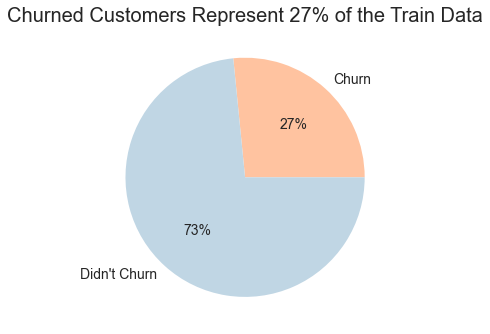

In [6]:
#show percentage of customers who churned from the train data
e.churn_percentage(train)

**A little over 1/4 of customers in the training data churn.**

## 2. Does a customer's tenure affect churn? 

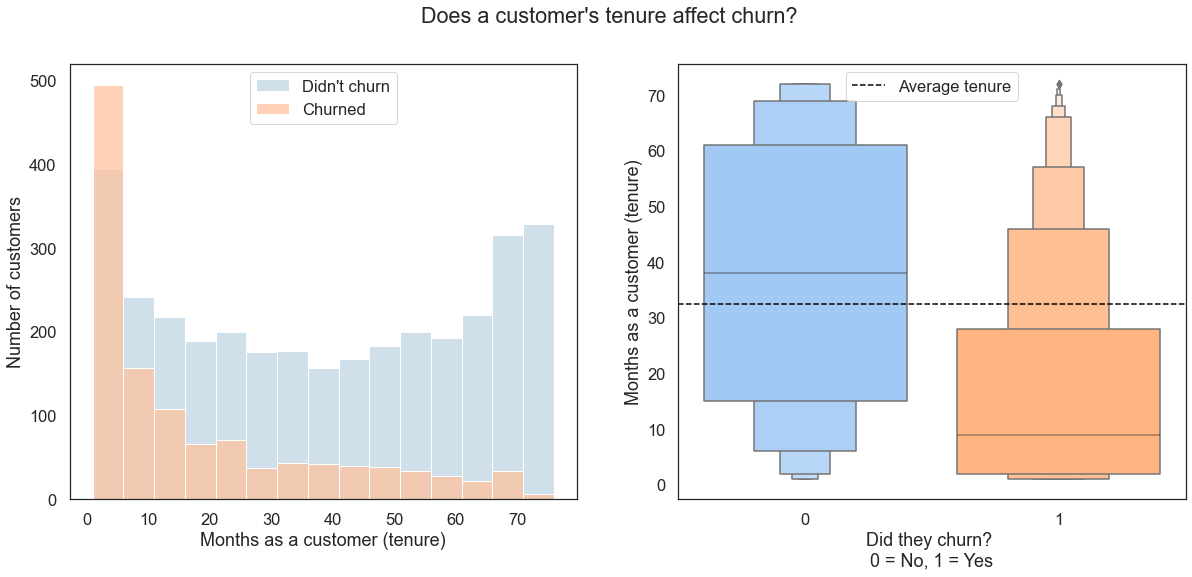

In [7]:
#plot tenure of those who churned and didn't churn
e.tenure_viz(train)

**It looks like those who have been a customer a shorter amount of time churn more**

**In order to confirm this prediction, I will now do a T-test to test for a significant difference between tenure of those who churn and don't churn**
* My confidence interval is 95%
* Resulting alpha is .05

In [8]:
#set alpha for my testing
alpha = 0.05

**To run a T-test we have to check our assumptions**
* **Independent:** Yes. Two separate groups churn and no_churn
* **Normal distribution:** Yes. Enough observations
* **Equal variances:** After running the ```stats.levene```, p < alpha so they are NOT equal and we must use ```equal_var = False```

**Set Hypothesis**

$H_0$ = There is no difference in tenure between those who churn and don't churn 

$H_a$ = There is a difference in tenure between those who churn and don't churn 

In [9]:
#run t-test and get results
e.tenure_ttest(train)

tstat: -29.127546
p-value: 6.457e-162


**p < alpha, so we can reject the null hypothesis and say there is probably a difference in tenure between those who churn and don't churn.** 

***Based on the visualizations and the results from the T-test, I think that tenure should be used in my model to help with the model's accuracy.***

## 3. Do higher monthly charges affect churn?

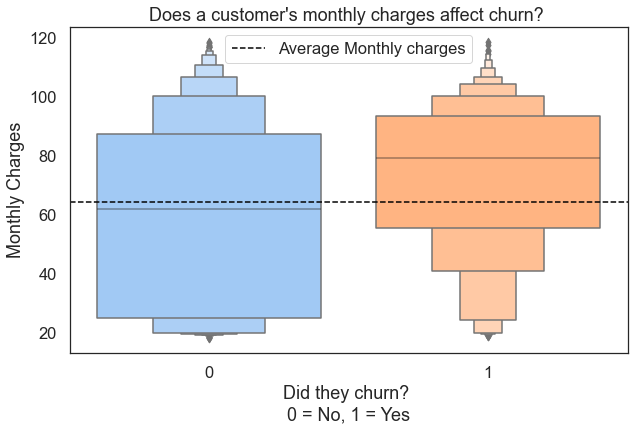

In [10]:
#plot monthly charges of those who churned and didn't churn
e.monthly_charges_viz(train)

**It looks like those who churn have higher monthly charges**

**In order to confirm this prediction, I will now do a T-test to test if average monthly charges of those who churn are higher than those who don't churn**
* My confidence interval is 95%
* Resulting alpha is .05

**To run a T-test we have to check our assumptions**
* **Independent:** Yes. Two separate groups churn and no_churn
* **Normal distribution:** Yes. Enough observations
* **Equal variances:** After running the ```stats.levene```, p < alpha so they are NOT equal and we must use ```equal_var = False```

$H_0$ = Average monthly charges of those who churn $\leq$ average monthly charges of those who don't churn

$H_a$ = Average monthly charges of those who churn $>$ average monthly charges of those who don't churn

In [11]:
#run t-test and get results
e.monthly_charges_ttest(train)

tstat: 14.5386
p-value: 3.64651e-46


**Since t > 0 and p/2 < alpha we can reject the null hypothesis and say monthly charges of those who churn are higher than those who don't churn.**

***Based on the visualizations and the results from the T-test, I think that monthly charges should be used in my model to help with the model's accuracy.***

## 4. Does contract type affect churn?

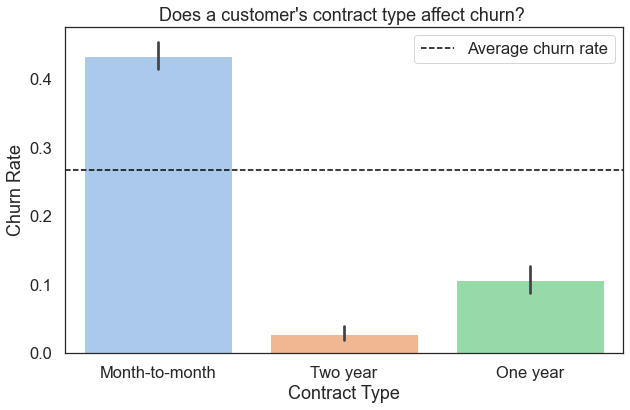

In [12]:
#plot different contract types compared to churn
e.contract_type_viz(train)

**It looks like those who have a month-to-month contract churn well above the average churn rate. I predict there is a relationship between contract type and churn**

**In order to confirm this prediction, I will now do a $\chi^2$ test to check if there is a relationship between contract type and churn**
* My confidence interval is 95%
* Resulting alpha is .05

$H_0$ = Contract type and churn are not related.

$H_a$ = Contract type and churn are related.

In [13]:
#run χ^2 test and get results
e.contract_type_chi(train)

χ^2: 803.239
p-value: 3.79161e-175


**Based on the visualizations and the results from the $\chi^2$ test, I think that contract type should be used in my model to help with the model's accuracy.**

## 5. Do those with no tech support churn more?

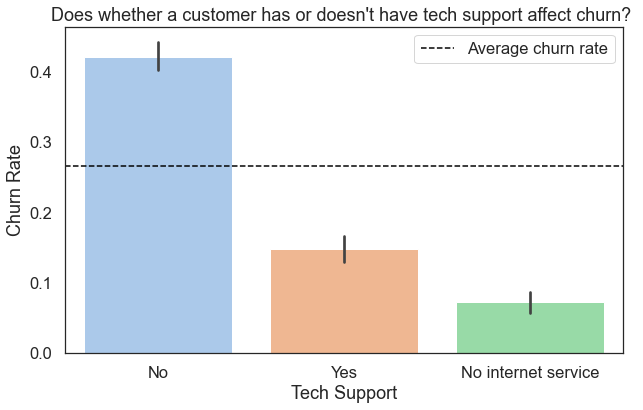

In [14]:
#plot tech support customers compared to churn
e.tech_support_viz(train)

**It looks like those who don't have tech suport might churn more. I predict there is a relationship between having tech support and churn**

$H_0$ = There is no relationship between having tech support and churn.

$H_a$ = There is a relationship between having tech support and churn.

In [15]:
#run χ^2 test and get results
e.tech_support_chi(train)

χ^2: 568.727
p-value: 3.18003e-124


**p < alpha, we can reject the null hypothesis and say there is evidence that tech support and churn are related.**

**Based on the visualizations and the results from the $\chi^2$ test, I think that tech support should be used in my model to help with the model's accuracy.**

### Exploration Summary
* Tenure seems to be a driver of churn
* Monthly_charges seem to be a driver of churn
* Contract_type seems to be a driver of churn
* Tech_support seems to be a driver of churn

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|tenure| From our t-test we saw there is probably a difference in tenure between those who churn and don't churn.|
|monthly_charges| From our t-test we saw there is probably a difference in monthly charges between those who churn and don't churn.|
|contract_type| From our $\chi^2$ test we saw there is probably a relationship between contract type and churn.|
|tech_support| From our $\chi^2$ test we saw there is probably a relationship between contract type and churn.|

In [16]:
#save drivers into a list
drivers = ['churn_encoded', 'tenure', 'monthly_charges', 'contract_type', 'tech_support']

### Features I'm not moving on with

| Feature | Reason | 
|:--------|:-----------|
|gender| No evidence that gender is a driver of churn
|senior_citizen| No evidence that senior_citizen is a driver of churn
|partner| Remove noise
|dependents| Remove noise
|phone_service| No evidence that phone_service is a driver of churn
|multiple_lines| No evidence that multiple_lines is a driver of churn
|online_security| Remove noise
|online_backup| Remove noise
|device_protection| Remove noise
|streaming_tv| Remove noise
|streaming_movies| Remove noise
|paperless_billing| Remove noise
|total_charges| There is a strong correlation between total_charges and tenure and between total_charges and monthly_charges. Since I will take tenure and monthly_charges into my model, total_charges is not needed.
|internet_service_type| Remove noise
|payment_type| Remove noise


# Modeling

* I will use accuracy as my evaluation metric
* I had looked at recall, but we cannot determine that false negatives are more costly unless we get more information from the company.
* Didn't churn customers make up 73% of the train data

In [17]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = m.prep_for_model(train, validate, test, "churn_encoded", drivers)

In [18]:
#baseline based on the percentage of the mode
baseline = y_train.value_counts(normalize=True).max()
#print results
print(f'Baseline accuracy: {baseline:.2%}')

Baseline accuracy: 73.43%


### Model Testing
* I evaluated on the four different model types and various hyperparameter configurations below
* Models were evaluated on train and validate data to prevent overfitting
* The model that performed the best was then run on the test data

### Decision Tree

In [19]:
#get decision tree model results
m.decision_tree_results(X_train, y_train, X_validate, y_validate)

Decision Tree
Train Accuracy: 79.57%
Validate Accuracy: 78.08%
Difference: 1.49%


### Random Forest

In [20]:
#get random forest model results
m.random_forest_results(X_train, y_train, X_validate, y_validate)

Random Forest
Train Accuracy: 79.94%
Validate Accuracy: 78.72%
Difference: 1.22%


### KNN

In [21]:
#get KNN model results
m.knn_results(X_train, y_train, X_validate, y_validate)

KNN
Train Accuracy: 84.43%
Validate Accuracy: 75.59%
Difference: 8.84%


### Logistic Regression

In [22]:
#get logistic regression model results
m.log_results(X_train, y_train, X_validate, y_validate)

Logistic Regression
Train Accuracy: 78.63%
Validate Accuracy: 79.36%
Difference: -0.73%


### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* KNN had a high train accuracy and lower validate accuracy so it is probably over fit.

### Best model: Random Forest Model 
* I chose the random forest model because the difference in accuracy between the train and validate is less than 1%
* I will now run the random forest model on test data to gauge how it will perform on future data

In [23]:
#get best model results on test data
m.best_model(X_train, y_train, X_test, y_test)

Best Model: Random Forest
Test Accuracy: 78.39%


**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

In [24]:
#get best model results across all data
m.best_model_comparison(X_train, y_train, X_validate, y_validate, X_test, y_test)

Random Forest
Train Accuracy: 79.94%
Validate Accuracy: 78.72%
Test Accuracy: 78.39%


## Conclusion

### Summary
* About 1/4 of our customers churn
* Tenure seems to be a driver of churn
* Monthly_charges seem to be a driver of churn
* Contract_type seems to be a driver of churn
* Tech_support seems to be a driver of churn


### Recommendations
* To reduce churn, I would encourage the company to think about taking the following actions:
    * Seek out young customers and give discounts (lower monthly cost) in order to keep customers longer (increase tenure)
    * Seek out month-to-month contract customers and encourage them to sign a longer contract maybe through discounts
    * Seek out those who don't have tech support and give a free trial of tech support.

### Next Steps
* In the next iteration:
    * Look into how customers with internet add-ons are the same people then can see if they churn more or less.
    * Look into cost of add-ons and see if there are bundles that might reduce monthly charges. That could help us entice more customers to stay.